In [1]:
import torchvision 
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset,DataLoader
import math
import os
from PIL import Image
from torchvision import transforms

In [2]:
class FSRCNN_data(Dataset):
    def __init__(self,image_dir,transform=None):

        self.image_dir=image_dir
        self.image_list=os.listdir(image_dir)
        self.transform=transform
        
      

    def __getitemimage__(self,index):
        
        image_path=os.path.join(self.image_dir,self.image_list[2*index+1])
        image = Image.open(image_path)
        
        transform = transforms.Compose([
            transforms.ToTensor(),          
        ])
        image = transform(image)
        
        mean = torch.Tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.Tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        image = (image - mean) / std
        
        return image
        
    def __getitemlabel__(self,index):
        
        
        label_path=os.path.join(self.image_dir,self.image_list[2*index])
        label = Image.open(label_path)
        transform = transforms.Compose([
            transforms.ToTensor(),
            
        ])
        label = transform(label)
        
        mean = torch.Tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.Tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        label = (label - mean) / std
        return label
        

    def __len__(self):
        return len(self.image_list)

    def plot_image(self, index):
        input_image, target_image = self.__getitem__(index)
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
        
        ax1.imshow(input_image)
        ax1.set_title('Input (Low Resolution)')
        ax1.axis('off')
        
        ax2.imshow(target_image)
        ax2.set_title('Target (High Resolution)')
        ax2.axis('off')
        
        plt.tight_layout()
        plt.show()

In [3]:
dataset=FSRCNN_data('BSD100/image_SRF_2')

In [4]:
x=dataset.__getitemlabel__(4)
print(x.shape)


torch.Size([3, 320, 480])


In [5]:
x=dataset.__getitemimage__(0)
print(x.shape)

torch.Size([3, 240, 160])


In [6]:
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional

In [7]:
class FSRCNN_model(nn.Module):
    def __init__(self):
        super(FSRCNN_model,self). __init__()
        # Feature extraction 
        self.conv1=nn.Conv2d(in_channels=3,out_channels=56,kernel_size=5,padding=2)
        self.prelu1=nn.PReLU()

        #Shrinking layer
        self.conv2=nn.Conv2d(56,12,1,padding=0)
        self.prelu2=nn.PReLU()

        # Mapping
        self.conv3=nn.Conv2d(12,12,3,padding=1)
        self.prelu3=nn.PReLU()
        
        self.conv4=nn.Conv2d(12,12,3,padding=1)
        self.prelu4=nn.PReLU()
        
        self.conv5=nn.Conv2d(12,12,3,padding=1)
        self.prelu5=nn.PReLU()
        
        self.conv6=nn.Conv2d(12,12,3,padding=1)
        self.prelu6=nn.PReLU()

        # Expansion
        self.conv7=nn.Conv2d(12,56,1,padding=0)
        self.prelu7=nn.PReLU()
        
        # deconvolution
        self.deconv = nn.ConvTranspose2d(56, 3, kernel_size=9, stride=2,padding=4, output_padding=1)
        
    def forward(self,X):
        #X=self.conv1(X)
        X=self.prelu1(self.conv1(X))
        #print(X.shape)
        
        #X=self.conv2(X)
        X=self.prelu2(self.conv2(X))
        #print(X.shape)
        
        #X=self.conv3(X)
        X=self.prelu3(self.conv3(X))
        #print(X.shape)
        
        #X=self.conv4(X)
        X=self.prelu4(self.conv4(X))
        #print(X.shape)
        
        #X=self.conv5(X)
        X=self.prelu5(self.conv5(X))
        #print(X.shape)
        
        #X=self.conv6(X)
        X=self.prelu6(self.conv6(X))
        #print(X.shape)
        
        #X=self.conv7(X)
        X=self.prelu7(self.conv7(X))
        #print(X.shape)
        
        X=self.deconv(X)
        #print(X.shape)
        return X
        

In [8]:
# VGG network
import torchvision.models as models

class VGGperceptualLoss(nn.Module):
    
    def __init__(self):
        super(VGGperceptualLoss,self).__init__()
        
        vgg=models.vgg16(pretrained=True).features.eval()
        
        self.vgg_layers=nn.ModuleList(vgg)
        self.layer_name_mapping={
            '3':"relu1_2",
            '8':"relu2_2",
            '15':"relu3_3",
                      
        }
    def forward(self,x,y):   
        x_vgg,y_vgg=x,y
        loss=0
        
        for name,module in self.vgg_layers._modules.items():
            x_vgg=module(x_vgg)
            y_vgg=module(y_vgg)
            if name in self.layer_name_mapping:
                loss+=nn.functional.l1_loss(x_vgg,y_vgg)
        return loss
        



C:\Users\roots\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\roots\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0, Loss: 0.7344686311483383
Epoch 1, Loss: 0.5089120429754257
Epoch 2, Loss: 0.48239158421754835
Epoch 3, Loss: 0.444125257730484
Epoch 4, Loss: 0.3775484450161457
Epoch 5, Loss: 0.36147337399423124
Epoch 6, Loss: 0.3164593081176281
Epoch 7, Loss: 0.3021284156292677
Epoch 8, Loss: 0.30653187200427057
Epoch 9, Loss: 0.2927382207661867
Epoch 10, Loss: 0.2880376908928156
Epoch 11, Loss: 0.2671134067326784
Epoch 12, Loss: 0.2643787269294262
Epoch 13, Loss: 0.25785269141197203
Epoch 14, Loss: 0.24304158478975296
Epoch 15, Loss: 0.24114238224923612
Epoch 16, Loss: 0.23669589042663575
Epoch 17, Loss: 0.2831377013027668
Epoch 18, Loss: 0.2644186770915985
Epoch 19, Loss: 0.2428892118483782


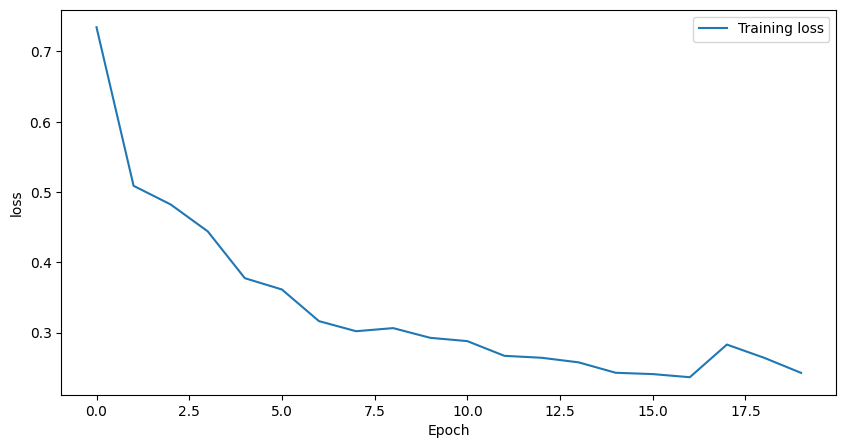

In [9]:
model=FSRCNN_model()
mse_loss=nn.MSELoss()
perceptual_loss=VGGperceptualLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)

epochs=20
batch_size=1
training_loss=[]

for i in range(epochs):
    running_loss=0
    
    for j in range(100):
        images=dataset.__getitemimage__(j)
        labels=dataset.__getitemlabel__(j)
        optimizer.zero_grad()
        outputs=model(images)
        mse=mse_loss(outputs,labels)
        perceptual=perceptual_loss(outputs,labels)
        total_loss=mse+0.1*perceptual
        total_loss.backward()
        optimizer.step()
        running_loss=running_loss+total_loss.item()
        
    training_loss.append(running_loss/100)
    print(f'Epoch {i}, Loss: {running_loss/100}' )

plt.figure(figsize=(10,5))
plt.plot(training_loss,label="Training loss")
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.legend()
plt.show()




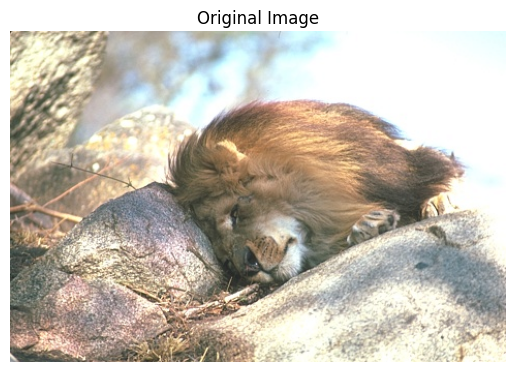

In [28]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

inv_normalize = transforms.Compose([
    transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
])

labels=dataset.__getitemlabel__(4)
img_denormalized = inv_normalize(labels.clone())

img_np = img_denormalized.cpu().permute(1, 2, 0).numpy()

img_np = np.clip(img_np, 0, 1)

plt.imshow(img_np)
plt.title('Original Image')
plt.axis('off')
plt.show()

In [13]:
import numpy as np
from PIL import Image
import math
import torch
import torch.nn as nn
import torchvision.transforms as transforms



def calculate_psnr(original_image, reconstructed_image):
  
    assert original_image.shape == reconstructed_image.shape, "Images must have the same dimensions"
    
    mse = np.mean((original_image - reconstructed_image) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 1.0
    psnr = 20 * math.log10(max_pixel / math.sqrt(mse))
    return psnr


PSNR value: 25.25 dB


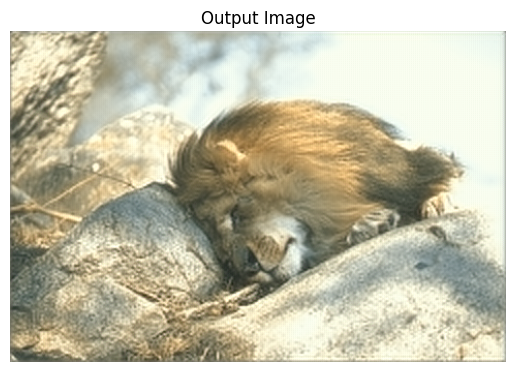

In [29]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


inv_normalize = transforms.Compose([
    transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
])


labels=dataset.__getitemlabel__(4)
images=dataset.__getitemimage__(4)
outputs=model(images)
img_denormalized = inv_normalize(outputs.clone())
img_denormalized_labels=inv_normalize(labels.clone())

img_np = img_denormalized.detach().cpu().permute(1, 2, 0).numpy()
img_np_labels=img_denormalized_labels.detach().cpu().permute(1,2,0).numpy()


img_np = np.clip(img_np, 0, 1)
img_np_labels=np.clip(img_np_labels,0,1)


psnr_value = calculate_psnr(img_np_labels, img_np)
print(f"PSNR value: {psnr_value:.2f} dB")


plt.imshow(img_np)
plt.title('Output Image')
plt.axis('off')
plt.show()

In [ ]:
# Testing 

In [30]:
dataset=FSRCNN_data('BSD100/image_SRF_4')

In [31]:
class FSRCNN_model(nn.Module):
    def __init__(self):
        super(FSRCNN_model,self). __init__()
        # Feature extraction 
        self.conv1=nn.Conv2d(in_channels=3,out_channels=56,kernel_size=5,padding=2)
        self.prelu1=nn.PReLU()

        #Shrinking layer
        self.conv2=nn.Conv2d(56,12,1,padding=0)
        self.prelu2=nn.PReLU()

        # Mapping
        self.conv3=nn.Conv2d(12,12,3,padding=1)
        self.prelu3=nn.PReLU()
        
        self.conv4=nn.Conv2d(12,12,3,padding=1)
        self.prelu4=nn.PReLU()
        
        self.conv5=nn.Conv2d(12,12,3,padding=1)
        self.prelu5=nn.PReLU()
        
        self.conv6=nn.Conv2d(12,12,3,padding=1)
        self.prelu6=nn.PReLU()

        # Expansion
        self.conv7=nn.Conv2d(12,56,1,padding=0)
        self.prelu7=nn.PReLU()
        
        # deconvolution
        self.deconv = nn.ConvTranspose2d(56, 3, kernel_size=9, stride=4,padding=4, output_padding=3)
    
    

     

        
    def forward(self,X):
        #X=self.conv1(X)
        X=self.prelu1(self.conv1(X))
        #print(X.shape)
        
        #X=self.conv2(X)
        X=self.prelu2(self.conv2(X))
        #print(X.shape)
        
        #X=self.conv3(X)
        X=self.prelu3(self.conv3(X))
        #print(X.shape)
        
        #X=self.conv4(X)
        X=self.prelu4(self.conv4(X))
        #print(X.shape)
        
        #X=self.conv5(X)
        X=self.prelu5(self.conv5(X))
        #print(X.shape)
        
        #X=self.conv6(X)
        X=self.prelu6(self.conv6(X))
        #print(X.shape)
        
        #X=self.conv7(X)
        X=self.prelu7(self.conv7(X))
        #print(X.shape)
        
        X=self.deconv(X)
        #print(X.shape)
        return X
        

Epoch 0, Loss: 0.8225023439526558
Epoch 1, Loss: 0.5638445100188255
Epoch 2, Loss: 0.5316337254643441
Epoch 3, Loss: 0.5176015804708004
Epoch 4, Loss: 0.48912832990288735
Epoch 5, Loss: 0.47623896300792695
Epoch 6, Loss: 0.4798998522758484
Epoch 7, Loss: 0.4681465384364128
Epoch 8, Loss: 0.44869700729846956
Epoch 9, Loss: 0.44071215063333513
Epoch 10, Loss: 0.4591845352947712
Epoch 11, Loss: 0.41794551953673365
Epoch 12, Loss: 0.3633949273824692
Epoch 13, Loss: 0.35497909009456635
Epoch 14, Loss: 0.35148193553090096
Epoch 15, Loss: 0.34729988902807235
Epoch 16, Loss: 0.3433068084716797
Epoch 17, Loss: 0.34198269367218015
Epoch 18, Loss: 0.35104079052805903
Epoch 19, Loss: 0.3415432259440422


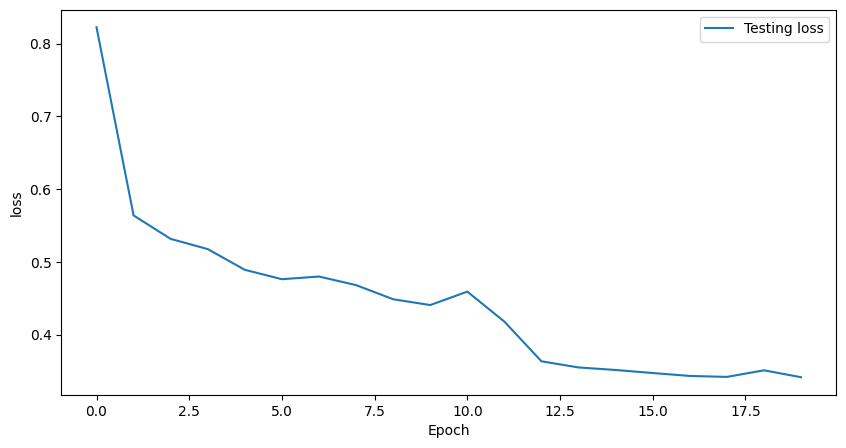

In [32]:
model=FSRCNN_model()
mse_loss=nn.MSELoss()
perceptual_loss=VGGperceptualLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)

epochs=20
batch_size=1
testing_loss=[]

for i in range(epochs):
    running_loss=0
    
    for j in range(100):
        images=dataset.__getitemimage__(j)
        labels=dataset.__getitemlabel__(j)
        optimizer.zero_grad()
        outputs=model(images)
        mse=mse_loss(outputs,labels)
        perceptual=perceptual_loss(outputs,labels)
        total_loss=mse+0.1*perceptual
        total_loss.backward()
        optimizer.step()
        running_loss=running_loss+total_loss.item()
        
    testing_loss.append(running_loss/100)
    print(f'Epoch {i}, Loss: {running_loss/100}' )

plt.figure(figsize=(10,5))
plt.plot(testing_loss,label="Testing loss")
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.legend()
plt.show()


PSNR value: 27.66 dB


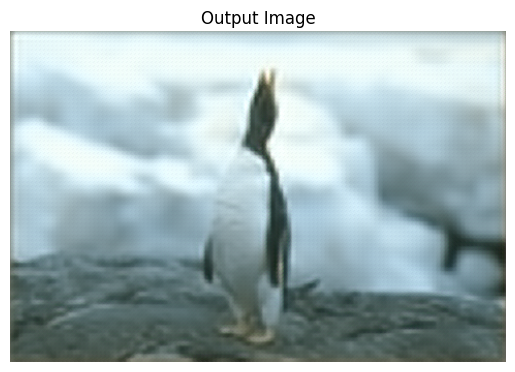

In [41]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

inv_normalize = transforms.Compose([
    transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
])


labels=dataset.__getitemlabel__(5)
images=dataset.__getitemimage__(5)
outputs=model(images)
img_denormalized = inv_normalize(outputs.clone())
img_denormalized_labels=inv_normalize(labels.clone())


img_np = img_denormalized.detach().cpu().permute(1, 2, 0).numpy()
img_np_labels=img_denormalized_labels.detach().cpu().permute(1,2,0).numpy()

img_np = np.clip(img_np, 0, 1)
img_np_labels=np.clip(img_np_labels,0,1)


psnr_value = calculate_psnr(img_np_labels, img_np)
print(f"PSNR value: {psnr_value:.2f} dB")

plt.imshow(img_np)
plt.title('Output Image')
plt.axis('off')
plt.show()